# Montevideo

Instance took from the set of bycicle network design problems faced by Inco.

In [1]:
from functools import partial
import os

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import networkx as nx

import bcnetwork as bc

## Utils

In [15]:
raw_data_path = '../instances/montevideo'
data_path = '../data/montevideo_v4'
resources_path = '../thesis/resources'

## General information

In [19]:
demand_df = pd.read_csv(os.path.join(raw_data_path, 'demands.csv'))
d3000_df = pd.read_csv(os.path.join(raw_data_path, 'demands_d3000.0.csv'))

print("Demand under 3000km:", d3000_df.demand.sum() / demand_df.demand.sum())
print("Top 600 demand under 3000km:", d3000_df.iloc[:600].demand.sum() / d3000_df.demand.sum())

Demand under 3000km: 0.4038320634230991
Top 600 demand under 3000km: 0.6766337179341706


## Draw solutions

Draw solutions computed by the CPLEX solver elsewhere.


In [3]:
def read_instances(data_path):
    instances = []

    for entry in os.scandir(data_path):
        if 'solution' in entry.path or not entry.path.endswith('pkl'):
            continue

        dirname, basename = os.path.dirname(entry.path), os.path.basename(entry.path)
        solution_path = os.path.join(dirname,'solution_' + basename)
        if not os.path.exists(solution_path):
            continue

        model = bc.model.Model.load(entry.path)
        solution = bc.solution.Solution.load(solution_path)

        instances.append((model, solution))
    
    return instances

In [4]:
draw_config = dict(
    figsize=(8, 7),
)

split_draw_config = dict()

In [5]:
instances = read_instances(data_path)

Sample Model out of 6 models
Nodes: 136
Edges: 636
Multigraph: False
Directed: True
OD count: 600
Breakpoint count: 10
Budget: 1296880.949638854


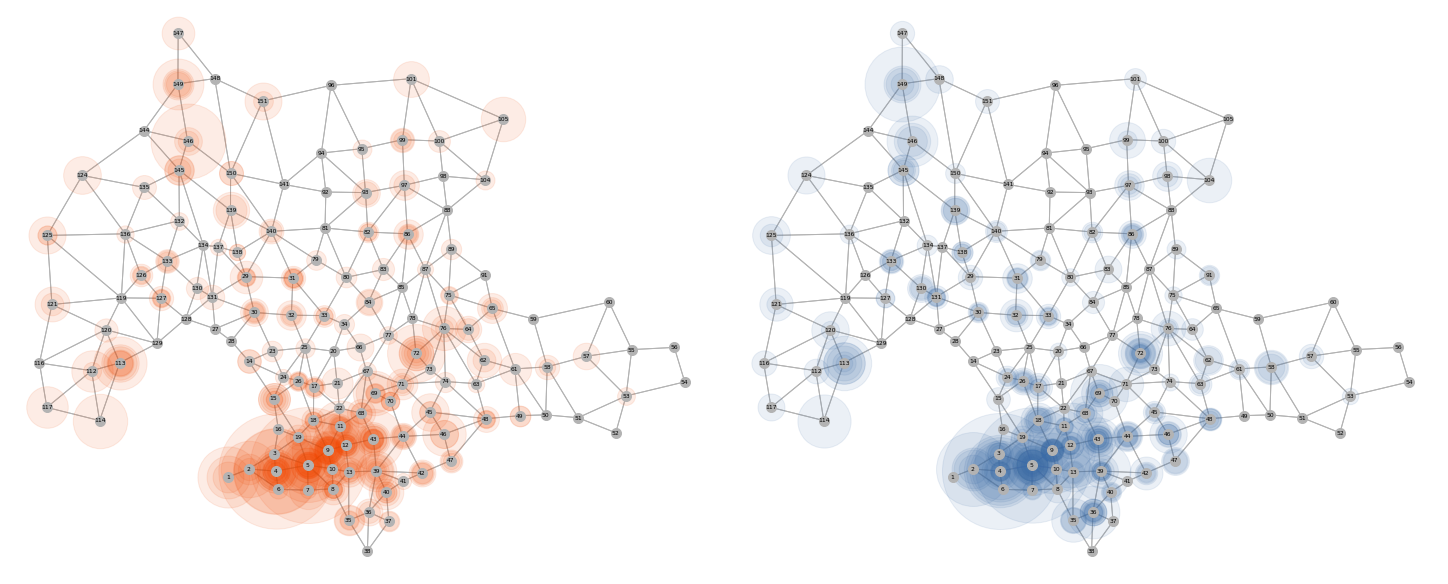

In [6]:
sample_model = instances[0][0]
sample_graph = sample_model.graph

print(f'Sample Model out of', len(instances), 'models')
print(f'Nodes: {sample_graph.number_of_nodes()}')
print(f'Edges: {sample_graph.number_of_edges()}')
print(f'Multigraph: {sample_graph.is_multigraph()}')
print(f'Directed: {sample_graph.is_directed()}')
print(f'OD count: {len(sample_model.odpairs)}')
print(f'Breakpoint count: {len(sample_model.breakpoints)}')
print(f'Budget: {sample_model.budget}')

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
bc.draw.draw(sample_model, odpairs=False, ax=axs[0], **split_draw_config)
bc.draw.draw_demand_weight(axs[0], sample_model, destination_color=None, show_top=300)

bc.draw.draw(sample_model, odpairs=False, ax=axs[1], **split_draw_config)
bc.draw.draw_demand_weight(axs[1], sample_model, origin_color=None, show_top=300)

fig.set(size_inches=(20, 8))
fig.savefig(os.path.join(resources_path, 'montevideo_demands.png'), dpi=300)

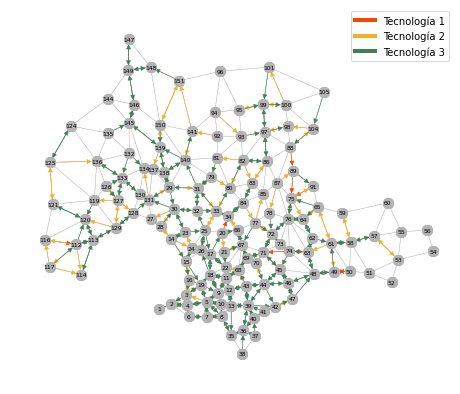

In [7]:
model, solution = instances[0]

bc.draw.draw(
    model,
    solution=solution,
    odpairs=False,
    infrastructures=True,
    width=0.3,
    **draw_config,
)

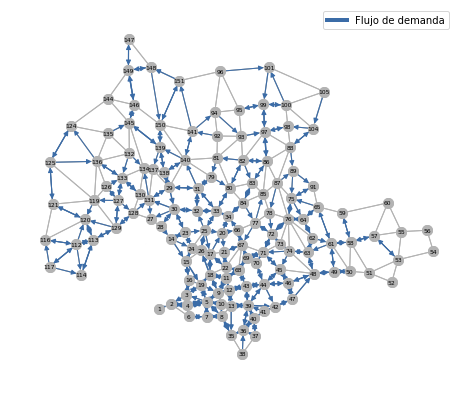

In [8]:
bc.draw.draw(
    model,
    solution=solution,
    odpairs=False,
    infrastructures=False,
    flows=True,
    **draw_config,
)

## Budget usage per instance

In [9]:
def get_budget_use_summary(data_path):
    df = pd.read_csv(os.path.join(data_path, 'abudget_use_summary.csv'))

    infra_length_columns = [c for c in df.columns if 'length' in c]
    df['total_length'] = df[infra_length_columns].fillna(0.0).apply(np.sum, axis=1)
    
    return df

In [10]:
bdf = get_budget_use_summary(data_path)

infra_length_columns = [c for c in bdf.columns if 'length' in c]

In [11]:
bdf[['name', 'total_length'] + infra_length_columns]

,name,total_length,infra_1_length_percentage,infra_2_length_percentage,infra_3_length_percentage,total_length
0,montevideo_d3000.0_linear_0.4_budget_factor,13.885881,0.588372,6.929961,6.367548,13.885881
1,montevideo_d3000.0_inv_logit_0.4_budget_factor,13.594649,0.354068,6.826881,6.413699,13.594649
2,montevideo_d3000.0_linear_0.8_budget_factor,26.158314,0.338838,11.886277,13.933198,26.158314
3,montevideo_d3000.0_inv_logit_0.8_budget_factor,27.041235,1.097719,12.470257,13.473259,27.041235
4,montevideo_d3000.0_linear_1.6_budget_factor,45.576712,1.045292,9.610020,34.921401,45.576712
5,montevideo_d3000.0_inv_logit_1.6_budget_factor,47.419548,1.392454,12.758019,33.269074,47.419548


## Desviacion sobre el camino más corto en distancia

Comparación entre el camino más corto en costo de usuario y el camino más corto en distancia.

Los datos son mostrados en por percentiles ponderados en segun la cantida de viajes, es decirl la demanda transferida de cada par origen-destino.

In [12]:
def get_shortest_path_cmp(model, solution):
    data = []
    
    graph = model.apply_solution_to_graph(solution)
    ods_demand = {
        f'{d.origin}-{d.destination}': d.demand_transfered
        for d in solution.data.demand_transfered
    }
    
    for (origin, destination, *_) in model.odpairs:      
        distance = nx.shortest_path_length(graph, origin, destination, weight='user_cost')
        user_cost_sp = nx.shortest_path(graph, origin, destination, weight='effective_user_cost')
        
        user_cost_distance = sum([
            graph.edges[n1, n2]['user_cost']
            for n1, n2 in zip(user_cost_sp[0:-1], user_cost_sp[1:])
        ])
        od = f'{origin}-{destination}'
        data.append(dict(
            od=od,
            distance=distance,
            user_cost_distance=user_cost_distance,
            ratio=user_cost_distance / distance,
            demand_transfered=ods_demand[od]
        ))
    

    df = pd.DataFrame(data)
    df = df[df.demand_transfered > 0.01]

    return df.sort_values(by=['ratio'])


def build_agg_dataset(dfs, instances, percentiles=[0.75, 0.9]):
    data = []
    for df, instance in zip(dfs, instances):
        model, solution = instance
        
        df_len = len(df)
        data_row = dict(
            name=model.name,
            od_affected=df_len,
        )
        
        total_demand = df.demand_transfered.sum()
        
        curr = 0
        percent = percentiles[:]
        percent = sorted(percent, reverse=True)
        curr_percentile = percent.pop()
        
        for _, row in df.iterrows():
            curr += row.demand_transfered
            
            if curr >= total_demand * curr_percentile:
                data_row[f'max{curr_percentile}'] = row.ratio

                if percent:
                    curr_percentile = percent.pop()
                else:
                    break
        data_row['max'] = df.iloc[-1].ratio
        data.append(data_row)
    
    return pd.DataFrame(data)

In [13]:
dfs = [get_shortest_path_cmp(*instance) for instance in instances]

In [37]:
aggdf = build_agg_dataset(dfs, instances, percentiles=[0.75, 0.90, 0.95, 0.98])

aggdf = aggdf.set_index('name').reindex(index=bdf.name).reset_index()

aggdodf = aggdf.round(2).assign(instance=range(1, len(aggdf) + 1)) \
                      [['instance'] + list(aggdf.columns.difference(['name', 'od_affected'], sort=False))] \
                      .to_csv(os.path.join(data_path, 'apath_deviation.csv'), index=False)


aggdf

,name,od_affected,max0.75,max0.9,max0.95,max0.98,max
0,montevideo_d3000.0_linear_0.4_budget_factor,395,1.0,1.000000,1.099187,1.172235,1.463773
1,montevideo_d3000.0_inv_logit_0.4_budget_factor,373,1.0,1.079842,1.110983,1.171046,1.433561
2,montevideo_d3000.0_linear_0.8_budget_factor,513,1.0,1.000000,1.082374,1.182645,1.433561
3,montevideo_d3000.0_inv_logit_0.8_budget_factor,510,1.0,1.038450,1.102971,1.172235,1.410136
4,montevideo_d3000.0_linear_1.6_budget_factor,598,1.0,1.000000,1.000000,1.097073,1.415032
5,montevideo_d3000.0_inv_logit_1.6_budget_factor,597,1.0,1.000000,1.009988,1.104241,1.331513
